
## SIMD Bitonic Sorting Network

This notebook presents the algorithm that evaluates a Bitonic Sorting Network using the _max_ function and SIMD computations. This approach allows to easily write the same algorithm using the CKKS primitives.

### Importing libraries

The *numpy* library will be useful as it will help us simulate SIMD computations. We also use *math* to compute logarithms and *matplotlib* to plot some numbers

In [144]:
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics

Defining a class to handle Remez approximations

In [145]:
class Chebyshev:
    """
    Chebyshev(a, b, n, func)
    Given a function func, lower and upper limits of the interval [a,b],
    and maximum degree n, this class computes a Chebyshev approximation
    of the function.
    Method eval(x) yields the approximated function value.
    """
    def __init__(self, a, b, n, func):
        self.a = a
        self.b = b
        self.func = func

        bma = 0.5 * (b - a)
        bpa = 0.5 * (b + a)
        f = [func(math.cos(math.pi * (k + 0.5) / n) * bma + bpa) for k in range(n)]
        fac = 2.0 / n
        self.c = [fac * sum([f[k] * math.cos(math.pi * j * (k + 0.5) / n)
                  for k in range(n)]) for j in range(n)]

    def eval(self, x):
        a,b = self.a, self.b
        #assert(a <= x <= b)
        y = (2.0 * x - a - b) * (1.0 / (b - a))
        y2 = 2.0 * y
        (d, dd) = (self.c[-1], 0)             # Special case first step for efficiency
        for cj in self.c[-2:0:-1]:            # Clenshaw's recurrence
            (d, dd) = (y2 * d - dd + cj, d)
        return y * d - dd + 0.5 * self.c[0]   # Last step is different
    
def relu(x):
    return np.maximum(0, x)

def inf_norm(real, approx):
    norm = 0
    for i in range(len(real)):
        diff = abs(real[i] - approx[i])
        if diff > norm:
            norm = diff
    return norm

## Defining primitive functions

This set of functions can be trivially written as CKKS homomorphic operations

In [146]:
def add(a, b):
    """
    Adds two arrays element-wise.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise sum of input arrays.
    """
    return np.add(a, b)

def add_many(values):
    """
    Sums up multiple arrays contained in the values list.

    Parameters:
    values (list of array-like): List containing arrays to be summed.

    Returns:
    numpy.ndarray: Sum of all arrays in the values list.
    """
    res = np.zeros(len(values[0]), dtype=int)
    for value in values:
        res = add(res, value)
    return res

def sub(a, b):
    """
    Subtracts one array from another element-wise.

    Parameters:
    a (array-like): The array to be subtracted from.
    b (array-like): The array to subtract.

    Returns:
    numpy.ndarray: Element-wise difference of the two input arrays.
    """
    return np.add(a, -b)

def mul(a, b):
    """
    Multiplies two arrays element-wise.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise product of input arrays.
    """
    return np.multiply(a, b)

def mask(a, index):
    """
    Masks elements of array a at the specified index with 1 and multiplies with the array.

    Parameters:
    a (array-like): The input array.
    index (int): Index to be masked.

    Returns:
    numpy.ndarray: Array with specified index masked with 1.
    """
    mask_vector = np.zeros(len(a), dtype=int)
    mask_vector[index] = 1
    return mul(a, mask_vector)

def rot(a, index):
    """
    Rotates the array to the left by the specified number of positions.

    Parameters:
    a (array-like): The input array.
    index (int): Number of positions to rotate the array to the left.

    Returns:
    numpy.ndarray: Array rotated to the left by the specified number of positions.
    """
    return np.roll(a, -index)

def f_min(a, b):
    """
    Computes the element-wise minimum of two arrays.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    ans = []
    for i in range(len(a)):
        ans.append(min(a[i], b[i]))
    return np.array(ans)

def f_min_remez(a, b):
    """
    Computes the element-wise minimum of two arrays.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    ans = []
    for i in range(len(a)):
        ans.append(a[i] - poly_relu_remez.eval(a[i] - b[i]))
    return np.array(ans)

def f_min_cheby(a, b):
    """
    Computes the element-wise minimum of two arrays.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    return sub(a, np.vectorize(poly_relu_cheby.eval)(sub(a, b)))

Now we define the _swap_ function that will heavily be used throughout the evaluation of the Sorting Network

In [147]:
def swap_simd(a, delta, b = 0, l = 0, poly = True):    
    """
    Computes a parallel evaluation of a Sorting Network

    Parameters:
    a (array-like): Input array
    delta (int): The value of delta. In a sorting network, it specifies the "length of the arrows".
    r (int): The current round of the sorting network
    s (int): The current stage of the sorting network

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    rot_positive = rot(a, delta)
    rot_negative = rot(a, -delta)
    
    # This is the evaluation of the non-linear function
    
    if poly:
        f = f_min_cheby(a, rot_positive)
    else:
        f = f_min(a, rot_positive)
            
    m1 = f
    m2 = sub(add(a, rot_negative), rot(f, -delta))
    m3 = sub(add(a, rot_positive), f)
    m4 = rot(f, -delta)
    
    masks = generate_masks(len(a), b, l)
    
    return add_many([mul(m1, masks[0]), 
                     mul(m2, masks[1]),
                     mul(m3, masks[2]),
                     mul(m4, masks[3])])

In [148]:
def generate_masks(length, b, l):
    """
    Da commentare
    """
    mask_1 = []
    mask_2 = []
    mask_3 = []
    mask_4 = []
    
    
    while len(mask_1) < length:    
        for _ in range(2 ** l):
            for _ in range(2 ** (b - l)):
                mask_1.append(1)
                mask_2.append(0)
                mask_3.append(0)
                mask_4.append(0)

            for _ in range(2 ** (b - l)):
                mask_1.append(0)
                mask_2.append(1)
                mask_3.append(0)
                mask_4.append(0)

        if len(mask_1) + (2 ** b) >= length:
            break
            
        for _ in range(2 ** l):
            for _ in range(2 ** (b - l)):
                mask_1.append(0)
                mask_2.append(0)
                mask_3.append(1)
                mask_4.append(0)
                
            for _ in range(2 ** (b - l)):
                mask_1.append(0)
                mask_2.append(0)
                mask_3.append(0)
                mask_4.append(1)

    
    return [mask_1, mask_2, mask_3, mask_4]

### Evaluating a Network

Let's start with a simple example, ordering two elements

## Sorting 2 elements

In [149]:
n = 2
a = np.arange(n) / n

vec = np.copy(a)

print(vec)

a.sort()

[0.  0.5]


Let's define the approximation with $d = 7$

In [150]:
poly_relu_cheby = Chebyshev(-1, 1, 7, relu)

In [151]:
for b in range(int(math.log2(n))):
    for l in range(b + 1): 
        delta = 2 ** (b - l)
        vec = swap_simd(vec, delta, b, l, poly = True)  
        
print("Before: {}\nAfter: {}".format(a, vec))
print("Infinity norm error: {}".format(inf_norm(a, vec)))
print("Precision bits: {}".format(-math.log2(inf_norm(a, vec))))

Before: [0.  0.5]
After: [-0.0132422  0.5132422]
Infinity norm error: 0.013242198630991464
Precision bits: 6.238713513952075


Now with $d=6$

In [152]:
poly_relu_cheby = Chebyshev(-1, 1, 6, relu)

In [153]:
for b in range(int(math.log2(n))):
    for l in range(b + 1): 
        delta = 2 ** (b - l)
        vec = swap_simd(vec, delta, b, l, poly = True)  
        
print("Before: {}\nAfter: {}".format(a, vec))
print("Infinity norm error: {}".format(inf_norm(a, vec)))
print("Precision bits: {}".format(-math.log2(inf_norm(a, vec))))

Before: [0.  0.5]
After: [-4.80258466e-05  5.00048026e-01]
Infinity norm error: 4.802584657176423e-05
Precision bits: 14.345829429330573


Even if the degree is smaller, the approximation has a smaller error with an odd degree.

## Sorting 16 elements

In [154]:
n = 16

a = np.arange(n) / n
np.random.shuffle(a)

vec = np.copy(a)
sorted_a = np.copy(a)
sorted_a.sort()

print(vec)

[0.375  0.4375 0.5    0.125  0.625  0.1875 0.875  0.5625 0.     0.75
 0.9375 0.6875 0.25   0.0625 0.3125 0.8125]


In [155]:
vec = np.copy(a)
poly_relu_cheby = Chebyshev(-1, 1, 26, relu)

for b in range(int(math.log2(n))):
    for l in range(b + 1): 
        delta = 2 ** (b - l)
        vec = swap_simd(vec, delta, b, l, poly = True) 
        
#print("Before: {}\nAfter: {}".format(a, vec))
print("Infinity norm error: {}".format(inf_norm(sorted_a, vec)))

Infinity norm error: 0.003416751748933411


We sample a vector of $2^{6} = 64$ elements

In [156]:
n = 2 ** 6

a = np.arange(n) / n
np.random.shuffle(a)

vec = np.copy(a)
print(vec)

[0.9375   0.71875  0.703125 0.765625 0.625    0.015625 0.5625   0.90625
 0.609375 0.140625 0.828125 0.203125 0.796875 0.578125 0.421875 0.8125
 0.859375 0.09375  0.53125  0.671875 0.96875  0.34375  0.1875   0.46875
 0.234375 0.953125 0.59375  0.921875 0.875    0.4375   0.359375 0.890625
 0.3125   0.078125 0.40625  0.546875 0.109375 0.28125  0.515625 0.25
 0.046875 0.       0.21875  0.78125  0.390625 0.15625  0.84375  0.65625
 0.453125 0.0625   0.375    0.03125  0.5      0.734375 0.6875   0.265625
 0.984375 0.484375 0.640625 0.296875 0.75     0.171875 0.328125 0.125   ]


In [157]:
a_backup = a
a_backup.sort()

Now we evaluate it using SIMD computations, in particular we will just use the _swap_simd_ function

In [158]:
for b in range(int(math.log2(n))):
    for l in range(b + 1): 
        delta = 2 ** (b - l)
        vec = swap_simd(vec, delta, b, l, poly = True)  
vec

array([-0.02436181,  0.01660858,  0.02151541,  0.0603901 ,  0.04654214,
        0.0854186 ,  0.08706951,  0.12626913,  0.10898541,  0.14793528,
        0.14986132,  0.18853304,  0.17017209,  0.20906467,  0.21047061,
        0.24926698,  0.23346786,  0.27385652,  0.27416838,  0.31553726,
        0.29654703,  0.33630761,  0.33803774,  0.37724632,  0.36083849,
        0.39967747,  0.40072219,  0.43949244,  0.42103368,  0.45960737,
        0.46005605,  0.49861997,  0.48363482,  0.52218322,  0.52300047,
        0.56153267,  0.54632531,  0.58600872,  0.58679814,  0.62660734,
        0.60852911,  0.64750686,  0.64888996,  0.68769173,  0.66852289,
        0.70706776,  0.70969555,  0.74828093,  0.73348685,  0.77232556,
        0.77401937,  0.81305714,  0.79417318,  0.83404923,  0.83541323,
        0.87457251,  0.85746268,  0.89626352,  0.90264629,  0.94170053,
        0.92471966,  0.96325172,  0.97143121,  1.01019436])

In [159]:
precision_bits = {}

for deg in range(1, 119):
    poly_relu_cheby = Chebyshev(-1, 1, deg, relu)
    vec = np.copy(a)
    for b in range(int(math.log2(n))):
        for l in range(b + 1): 
            delta = 2 ** (b - l)
            vec = swap_simd(vec, delta, b, l, poly = True) 
    print("Infinity norm for d = {}: {}".format(deg, inf_norm(a_backup, vec)))

Infinity norm for d = 1: 0.4843750000000002
Infinity norm for d = 2: 1.6291328435596428
Infinity norm for d = 3: 0.34076003146893347
Infinity norm for d = 4: 8134.969099320469
Infinity norm for d = 5: 0.22529849878822833
Infinity norm for d = 6: 0.29767839072788504
Infinity norm for d = 7: 0.1771097464933894
Infinity norm for d = 8: 0
Infinity norm for d = 9: 0.17117267999905827
Infinity norm for d = 10: 0.7022104412538828
Infinity norm for d = 11: 0.12850119924294767
Infinity norm for d = 12: 0
Infinity norm for d = 13: 0.10872081561053448
Infinity norm for d = 14: 0.5128262767708944
Infinity norm for d = 15: 0.10972897503152323
Infinity norm for d = 16: 0
Infinity norm for d = 17: 0.09992097977546938
Infinity norm for d = 18: 0.14294800975454341
Infinity norm for d = 19: 0.09343786263166876
Infinity norm for d = 20: 0.589011830179939
Infinity norm for d = 21: 0.08480453403196098
Infinity norm for d = 22: 0.04777365560231983
Infinity norm for d = 23: 0.0692747865219816
Infinity norm f

/var/folders/f4/cjlhwcw50v97ltsgj1fxyssm0000gn/T/ipykernel_16827/2807549886.py:28: RuntimeWarning: overflow encountered in scalar multiply
  (d, dd) = (y2 * d - dd + cj, d)
/var/folders/f4/cjlhwcw50v97ltsgj1fxyssm0000gn/T/ipykernel_16827/2807549886.py:28: RuntimeWarning: invalid value encountered in scalar subtract
  (d, dd) = (y2 * d - dd + cj, d)


Infinity norm for d = 50: 0.012601398061218294
Infinity norm for d = 51: 0.025023326918975464
Infinity norm for d = 52: 0.011917506682598944
Infinity norm for d = 53: 0.027264236191826052
Infinity norm for d = 54: 0.011153216528643428
Infinity norm for d = 55: 0.02984999540691452
Infinity norm for d = 56: 0.010353254181480143
Infinity norm for d = 57: 0.03137386529246072
Infinity norm for d = 58: 0.009670089870656817
Infinity norm for d = 59: 0.03212231846051117
Infinity norm for d = 60: 0.00897597249872567
Infinity norm for d = 61: 0.03218189019109241
Infinity norm for d = 62: 0.0082819519106907
Infinity norm for d = 63: 0.03231441879590202
Infinity norm for d = 64: 0.007604703551225667
Infinity norm for d = 65: 0.03243940180404947
Infinity norm for d = 66: 0.007033199545749769
Infinity norm for d = 67: 0.031922576483644605
Infinity norm for d = 68: 0.006691927849664547
Infinity norm for d = 69: 0.030904464917369978
Infinity norm for d = 70: 0.006352584491594926
Infinity norm for d = 

In [160]:
precision_bits = {}

for deg in range(10, 119):
    poly_relu_cheby = Chebyshev(-1, 1, deg, relu)
    vec = np.copy(a)
    for b in range(int(math.log2(n))):
        for l in range(b + 1): 
            delta = 2 ** (b - l)
            vec = swap_simd(vec, delta, b, l, poly = True)   
    print("Precision bits for d = {}: {}".format(deg, round(-math.log2(max(abs(a_backup - vec))), 2)))
    precision_bits[deg] = round(-math.log2(max(abs(sub(a_backup, vec)))), 2)
    

Precision bits for d = 10: 0.51
Precision bits for d = 11: 2.96
Precision bits for d = 12: nan
Precision bits for d = 13: 3.2
Precision bits for d = 14: 0.96
Precision bits for d = 15: 3.19
Precision bits for d = 16: nan
Precision bits for d = 17: 3.32
Precision bits for d = 18: 2.81
Precision bits for d = 19: 3.42
Precision bits for d = 20: 0.76
Precision bits for d = 21: 3.56
Precision bits for d = 22: 4.39
Precision bits for d = 23: 3.85
Precision bits for d = 24: 1.73
Precision bits for d = 25: 4.1
Precision bits for d = 26: 4.81
Precision bits for d = 27: 4.12
Precision bits for d = 28: 2.8
Precision bits for d = 29: 4.06
Precision bits for d = 30: 5.12
Precision bits for d = 31: 4.06
Precision bits for d = 32: 4.1
Precision bits for d = 33: 4.09
Precision bits for d = 34: 5.46
Precision bits for d = 35: 4.14
Precision bits for d = 36: 5.28
Precision bits for d = 37: 4.17
Precision bits for d = 38: 5.63
Precision bits for d = 39: 4.26
Precision bits for d = 40: 5.71
Precision bits

/var/folders/f4/cjlhwcw50v97ltsgj1fxyssm0000gn/T/ipykernel_16827/2807549886.py:28: RuntimeWarning: overflow encountered in scalar multiply
  (d, dd) = (y2 * d - dd + cj, d)
/var/folders/f4/cjlhwcw50v97ltsgj1fxyssm0000gn/T/ipykernel_16827/2807549886.py:28: RuntimeWarning: invalid value encountered in scalar subtract
  (d, dd) = (y2 * d - dd + cj, d)


Precision bits for d = 83: 5.28
Precision bits for d = 84: 7.55
Precision bits for d = 85: 5.34
Precision bits for d = 86: 7.59
Precision bits for d = 87: 5.42
Precision bits for d = 88: 7.63
Precision bits for d = 89: 5.54
Precision bits for d = 90: 7.66
Precision bits for d = 91: 5.65
Precision bits for d = 92: 7.71
Precision bits for d = 93: 5.78
Precision bits for d = 94: 7.76
Precision bits for d = 95: 5.94
Precision bits for d = 96: 7.82
Precision bits for d = 97: 6.17
Precision bits for d = 98: 7.89
Precision bits for d = 99: 6.45
Precision bits for d = 100: 7.98
Precision bits for d = 101: 6.72
Precision bits for d = 102: 8.02
Precision bits for d = 103: 6.83
Precision bits for d = 104: 8.06
Precision bits for d = 105: 6.57
Precision bits for d = 106: 8.1
Precision bits for d = 107: 6.39
Precision bits for d = 108: 8.14
Precision bits for d = 109: 6.28
Precision bits for d = 110: 8.19
Precision bits for d = 111: 6.21
Precision bits for d = 112: 8.24
Precision bits for d = 113: 

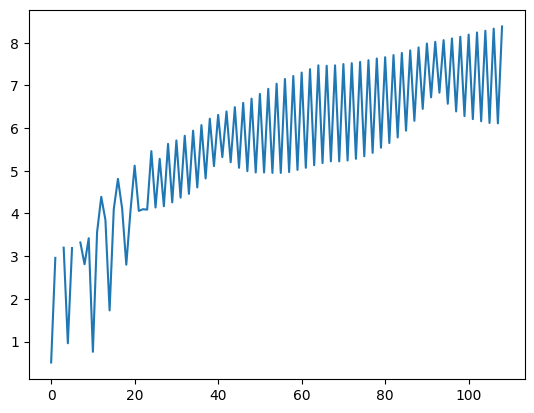

In [161]:
plt.plot(list(precision_bits.values()))

In [162]:
print("Real sorted: {}\nPoly sorted: {}".format(a * n, vec * n))

Real sorted: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63.]
Poly sorted: [ 0.17822862  1.05981519  1.92193531  2.81593646  4.19228285  5.08699947
  5.94766548  6.84803578  8.15235235  9.05235661  9.91312791 10.80905681
 12.18283858 13.08068306 13.93841604 14.8470916  16.15299088 17.06142543
 17.91940536 18.81733914 20.19073218 21.0867866  21.94783445 22.84745877
 24.15246898 25.05209889 25.91312712 26.80858322 28.18165425 29.08217293
 29.93392041 30.8541186  32.1458814  33.06607959 33.91782707 34.81834575
 36.19141678 37.08687288 37.94790111 38.84753102 40.15254123 41.05216555
 41.9132134  42.80926782 44.18266086 45.08059464 45.93857457 46.84700912
 48.1529084  49.06158396 49.91931694 50.81716142 52.19094319 53.08687209
 53.94764339 54.84764765 56.15196422 57.05233452 57.9130